## Imports

In [1]:
import os
import sys
sys.path.append("../")
import csv
import json
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

import settings
from prediction_dataset import PredictionDataset
from process_sentinel3 import OLCIdataGenerator

from collections import defaultdict
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn import tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import pickle
from math import isnan

from utils import parse_ficocianina_xls

## Methods

In [2]:
def metrics(gt, pred, labels=["No Bloom", "Bloom"]):
    metrics = {}
    metrics["accuracy"] = round(accuracy_score(gt, pred), 2)
    metrics["precision"] = round(precision_score(gt, pred, pos_label=labels[1]), 2)
    metrics["recall"] = round(recall_score(gt, pred, pos_label=labels[1]), 2)
    metrics["confusion matrix"] = confusion_matrix(gt, pred, labels=labels)
    metrics["false positive rate"] = round(metrics["confusion matrix"][1, 0]/(metrics["confusion matrix"][1, 1] + metrics["confusion matrix"][1, 0]), 2)
    metrics["false negative rate"] = round(metrics["confusion matrix"][0, 1]/(metrics["confusion matrix"][0, 0] + metrics["confusion matrix"][0, 1]), 2)
    
    return metrics

def metrics_multiclass(gt, pred, labels=["No Bloom", "Bloom", "Pre Bloom"]):
    metrics = {}
    metrics["confusion matrix"] = confusion_matrix(gt, pred, labels=labels)
    # Calculate accuracy for each class
    class_accuracy = {}
    for i, label in enumerate(labels):
        true_positive = metrics["confusion matrix"][i, i]
        total_samples = np.sum(metrics["confusion matrix"][i, :])
        class_accuracy[label] = true_positive / total_samples
    metrics["Accuracy"] = class_accuracy
    return metrics

In [3]:
processed_data_path = settings.processed_data_path

DATE_FORMAT = '%Y-%m-%d'

ndci_data_path = os.path.join(settings.final_data_path, "kmeans_3", "ndci_data.csv")
precipitation_data_path = os.path.join(settings.final_data_path, "precipitation", "precipitation_pdir.csv")
wind_data_path = os.path.join(settings.final_data_path, "wind_data.csv")
water_temperature_data_path = os.path.join(settings.final_data_path, "water_temperature.csv")
algae_gt_path = os.path.join(settings.final_data_path, "algae_gt.csv")
ta_ose_path = os.path.join(settings.final_data_path, "agua_open_data(1).csv")
s3_brrs_path = os.path.join(settings.final_data_path, "s3_brrs.json")

raw_cyano_gt_path = os.path.join(settings.final_data_path, "MUESTREOS_SEMANALES_2016-2017-2018-2019-2020.xls")

# bloom_thresholds = {
#                     "MALLORQUINA":5000,
#                     "ARROYO SAUCE": 5000,
#                     "SAUCE NORTE": 5000,
#                     "SAUCE SUR": 5000,
#                     "CISNES": 5000,
#                     "POTRERO": 5000,
#                     "TA":5000
#                    }
bloom_thresholds = {
                    "MALLORQUINA":5000,
                    "ARROYO SAUCE": 5000,
                    "SAUCE NORTE": 7000,
                    "SAUCE SUR": 7000,
                    "CISNES": 5000,
                    "POTRERO": 5000,
                    "TA":3000
                   }

sampling_points_coords = {"SAUCE NORTE": [-34.795398, -55.047355],
                          "SAUCE SUR": [-34.843127, -55.064624],
                          "TA": [-34.829670, -55.049758]}

pre_bloom_max_days = 7

In [4]:
dataset = PredictionDataset(wind_data_path, water_temperature_data_path, precipitation_data_path, 
                            ndci_data_path, algae_gt_path, s3_brrs_path, bloom_thresholds=bloom_thresholds, 
                            pre_bloom_max_days=pre_bloom_max_days)

../prediction_dataset.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df['label'] = location_df['fico'].apply(lambda x: 'Bloom' if x > threshold else 'No Bloom')
../prediction_dataset.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data_df["days until bloom"] = days_until_bloom


In [5]:
dataset.algae_gt

,date,location,fico,chl,label
0,2015-12-30,MALLORQUINA,5032.5,10.00,Bloom
5,2015-12-30,POTRERO,5843.5,13.20,Bloom
1,2015-12-30,ARROYO SAUCE,5345.5,21.80,Bloom
2,2015-12-30,SAUCE NORTE,4282.5,7.50,No Bloom
4,2015-12-30,CISNES,9082.5,18.45,Bloom
...,...,...,...,...,...
807,2023-02-25,ARROYO SAUCE,1420.5,3.30,No Bloom
812,2023-02-25,POTRERO,2353.5,3.90,No Bloom
808,2023-02-25,MALLORQUINA,1812.0,3.80,No Bloom
811,2023-02-25,CISNES,1669.0,3.60,No Bloom


In [6]:
dataset.bloom_forecast_gt[dataset.bloom_forecast_gt["location"] == "SAUCE NORTE"]

,date,location,fico,chl,label,days until bloom,forecast label
2,2015-12-30,SAUCE NORTE,4282.5,7.50,No Bloom,8,No Bloom
11,2016-01-07,SAUCE NORTE,11768.0,10.35,Bloom,0,Bloom
14,2016-01-13,SAUCE NORTE,12766.0,9.70,Bloom,0,Bloom
23,2016-01-23,SAUCE NORTE,2061.0,6.10,No Bloom,4,Pre Bloom
26,2016-01-27,SAUCE NORTE,9844.0,28.25,Bloom,0,Bloom
...,...,...,...,...,...,...,...
785,2023-01-27,SAUCE NORTE,50011.5,4.75,Bloom,0,Bloom
791,2023-02-02,SAUCE NORTE,32184.5,3.75,Bloom,0,Bloom
797,2023-02-09,SAUCE NORTE,51007.5,4.75,Bloom,0,Bloom
803,2023-02-15,SAUCE NORTE,6142.0,3.10,No Bloom,999,No Bloom


## Blooming detection with MPH

In [7]:
# create generator that yields instances of OLCIdata from dates with ground truth
# data corrupted by clouds is skipped
data_generator = OLCIdataGenerator(processed_data_path, DATE_FORMAT, skip_invalid=True)

y_gt = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

y_pred = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

predicted_dates = {"SAUCE NORTE": [],
                    "SAUCE SUR": [],
                    "TA": []}
duplicated_pixel_distribution = []
for olci_data in data_generator:
    total_pixels = olci_data.duplicated.shape[0] * olci_data.duplicated.shape[1]
    total_duplicated_pixels = np.count_nonzero(olci_data.duplicated)
    duplicated_pixel_distribution.append(total_duplicated_pixels/total_pixels)
    # get gt data for same date as OLCI data
    day_fico_df = dataset.algae_gt[dataset.algae_gt["date"] == olci_data.date.replace(hour=0, minute=0, second=0, microsecond=0)]
    # iterate over rows, skipping unwanted gt data
    for index, row in day_fico_df.iterrows():
        if not (row["location"] in y_gt):
            continue
        
        location_name = row["location"]
        location_coords = sampling_points_coords[location_name]
        
        mph_bloom_pred = olci_data.get_mph_bloom_in_locations([location_coords])

        y_pred[row["location"]].append("Bloom" if mph_bloom_pred == True else "No Bloom")
        y_gt[row["location"]].append(row["label"])
        predicted_dates[row["location"]].append(olci_data.date)

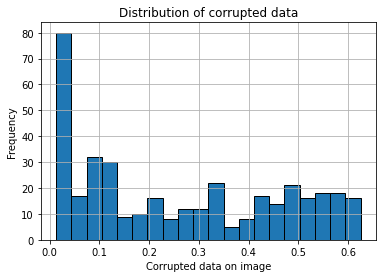

In [8]:
plt.hist(duplicated_pixel_distribution, bins=20, edgecolor='black')
plt.xlabel('Corrupted data on image')
plt.ylabel('Frequency')
plt.title('Distribution of corrupted data')
plt.grid(True)
plt.show()

SAUCE NORTE
Accuracy: 0.86
Precision: 0.65
Recall: 1.0
FPR: 0.0
FNR: 0.19


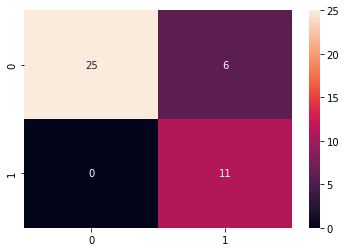

SAUCE SUR
Accuracy: 0.86
Precision: 0.65
Recall: 1.0
FPR: 0.0
FNR: 0.19


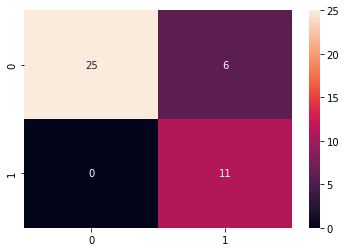

TA
Accuracy: 0.86
Precision: 0.76
Recall: 1.0
FPR: 0.0
FNR: 0.26


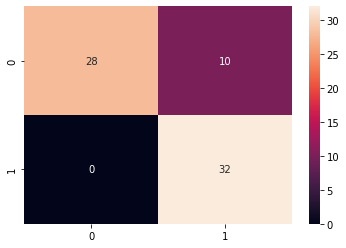

In [9]:
for location in list(y_gt.keys()):
    print(location)
    m = metrics(y_gt[location], y_pred[location])
    print("Accuracy:", m["accuracy"])
    print("Precision:", m["precision"])
    print("Recall:", m["recall"])
    print("FPR:", m["false positive rate"])
    print("FNR:", m["false negative rate"])
    sns.heatmap(m["confusion matrix"], annot=True)
    plt.show()

## Climate features (rain, temperature and wind) correlations with ficocyanin

In [10]:
sample_date = datetime(2020, 12, 1)
dataset.get_historic_data(sample_date, 5)[["date", "wind", "temperature", "precipitation"]]

,date,wind,temperature,precipitation
0,2020-12-01,4.5,17.0,0.250000
1,2020-11-30,14.5,17.0,1.121622
2,2020-11-29,13.5,21.0,1.516892
3,2020-11-28,12.0,21.5,5.449324
4,2020-11-27,9.0,18.0,0.000000


In [6]:
sample_date = datetime(2020, 12, 1)
dataset.get_historic_data(sample_date, 250)[["date", "precipitation"]]

,date,precipitation
0,2020-12-01,0.250000
1,2020-11-30,1.121622
2,2020-11-29,1.516892
3,2020-11-28,5.449324
4,2020-11-27,0.000000
...,...,...
245,2020-03-31,0.037162
246,2020-03-30,0.395270
247,2020-03-29,3.216216
248,2020-03-28,5.945946


In [30]:
infinite_defaultdict = lambda: defaultdict(infinite_defaultdict)
correlations = infinite_defaultdict() 

accumulation_methods = ["sum", "mean"]
# try to find correlations accumulating data in different amounts of days before the dates with GT
for days_before in [100, 200, 250, 365]:
    accumulation_data = []
    for index, row in dataset.algae_gt.iterrows():
        if row["location"] not in ["SAUCE NORTE", "SAUCE SUR", "TA"]:
            continue

        row_date = datetime(row["date"].year, row["date"].month, row["date"].day, 0, 0, 0)
        historic_data = dataset.get_historic_data(row_date, days_before)

        if len(historic_data) == 0: continue

        item = {"date": row["date"], "label": row["label"], "fico": row["fico"]}
        for m in accumulation_methods:
            item["precipitation_" + m] = getattr(historic_data["precipitation"], m)()
#             item["temperature_" + m] = getattr(historic_data["temperature"], m)()
#             item["wind_" + m] = getattr(historic_data["wind"], m)()
        accumulation_data.append(item)
    
    accumulation_df = pd.DataFrame(accumulation_data)
    accumulation_df = accumulation_df[accumulation_df["date"] >= datetime(2016, 11, 1)]
    accumulation_df["Bloom state"] = accumulation_df["label"].replace("No Bloom", 0)
    accumulation_df["Bloom state"] = accumulation_df["Bloom state"].replace("Bloom", 1)
    accumulation_df = accumulation_df.groupby('date').agg({'fico': 'mean', 
                                     'Bloom state': 'sum', 
                                     'precipitation_sum': 'mean',
                                     'precipitation_mean': 'mean'}).reset_index()
    accumulation_df['Bloom state'] = accumulation_df['Bloom state'].replace(2, 1)
    
    print(f"{days_before} days accumulation")
#     for d in ["precipitation", "temperature", "wind"]:
    for d in ["precipitation"]:
        for m in accumulation_methods:
            accumulation_dataname = f"{d}_{m}"
            accumulation_correlation_binary = accumulation_df['Bloom state'].corr(accumulation_df[accumulation_dataname])
            accumulation_correlation_cont = accumulation_df['fico'].corr(accumulation_df[accumulation_dataname])
            print(f"{accumulation_dataname} with binary ----> {round(accumulation_correlation_binary, 2)}")
            print(f"{accumulation_dataname} with continuous ----> {round(accumulation_correlation_cont, 2)}")
            correlations[d][days_before][m] = accumulation_correlation
    print("////////////")

100 days accumulation
precipitation_sum with binary ----> -0.23
precipitation_sum with continuous ----> -0.17
precipitation_mean with binary ----> -0.23
precipitation_mean with continuous ----> -0.17
////////////
200 days accumulation
precipitation_sum with binary ----> -0.41
precipitation_sum with continuous ----> -0.23
precipitation_mean with binary ----> -0.41
precipitation_mean with continuous ----> -0.23
////////////
250 days accumulation
precipitation_sum with binary ----> -0.39
precipitation_sum with continuous ----> -0.29
precipitation_mean with binary ----> -0.39
precipitation_mean with continuous ----> -0.29
////////////
365 days accumulation
precipitation_sum with binary ----> -0.26
precipitation_sum with continuous ----> -0.15
precipitation_mean with binary ----> -0.26
precipitation_mean with continuous ----> -0.15
////////////


In [ ]:
accumulation_df

In [18]:
dataset.algae_gt

,date,location,fico,chl,label
0,2015-12-30,MALLORQUINA,5032.5,10.00,Bloom
5,2015-12-30,POTRERO,5843.5,13.20,Bloom
1,2015-12-30,ARROYO SAUCE,5345.5,21.80,Bloom
2,2015-12-30,SAUCE NORTE,4282.5,7.50,No Bloom
4,2015-12-30,CISNES,9082.5,18.45,Bloom
...,...,...,...,...,...
807,2023-02-25,ARROYO SAUCE,1420.5,3.30,No Bloom
812,2023-02-25,POTRERO,2353.5,3.90,No Bloom
808,2023-02-25,MALLORQUINA,1812.0,3.80,No Bloom
811,2023-02-25,CISNES,1669.0,3.60,No Bloom


100 days accumulation

precipitation_sum ----> -0.164772164671051

precipitation_mean ----> -0.16477216467105096

temperature_sum ----> -0.021495860696549334

temperature_mean ----> 0.17807973954938786

wind_sum ----> -0.08023041408997561

wind_mean ----> 0.04708881066590756

////////////

200 days accumulation

precipitation_sum ----> -0.34936806032973905

precipitation_mean ----> -0.3493680603297392

temperature_sum ----> -0.007412263333156455

temperature_mean ----> 0.30830976785697606

wind_sum ----> -0.1207722832259705

wind_mean ----> -0.026601503894354672

////////////

250 days accumulation

precipitation_sum ----> -0.31982247835536526

precipitation_mean ----> -0.3198224783553651

temperature_sum ----> -0.06194357704347986


temperature_mean ----> 0.24057142004327892

wind_sum ----> -0.14626532732664888

wind_mean ----> -0.06596991010549

////////////

365 days accumulation

precipitation_sum ----> -0.15461669687502005

precipitation_mean ----> -0.15461669687502025

temperature_sum ----> -0.1647088816436126

temperature_mean ----> 0.056417708576601784

wind_sum ----> -0.13282270840171664

wind_mean ----> -0.02083764215671592

////////////

## Prediction with MPH features

In [12]:
data_generator = OLCIdataGenerator(processed_data_path, DATE_FORMAT, skip_invalid=True)

X = []
y = []
dates_list = []
locations_list = []

for olci_data in data_generator:
    # get gt data for same date as OLCI data
    day_fico_df = dataset.algae_gt[dataset.algae_gt["date"] == olci_data.date.replace(hour=0, 
                                                                                      minute=0, 
                                                                                      second=0, 
                                                                                      microsecond=0)]
    # iterate over rows, skipping unwanted gt data
    for index, row in day_fico_df.iterrows():
        if not (row["location"] in ["SAUCE NORTE", "SAUCE SUR", "TA"]):
            continue
            
        dates_list.append(row["date"])
        
        locations_list.append(row["location"])
            
        y.append(row["label"])
        
        location_coords = sampling_points_coords[row["location"]]
        
        i, j = olci_data.get_pos_index(location_coords[0], location_coords[1])
        
        # get mean of 3x3 grid centered on the sampling location for every feature
        NDVI = olci_data.mph.NDVI[i-1:i+2, j-1:j+2].mean()
        BAIR = olci_data.mph.BAIR[i-1:i+2, j-1:j+2].mean()
        SICF = olci_data.mph.SICF[i-1:i+2, j-1:j+2].mean()
        SIPF = olci_data.mph.SIPF[i-1:i+2, j-1:j+2].mean()
        MPH0 = olci_data.mph.MPH0[i-1:i+2, j-1:j+2].mean()
        MPH1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].mean()
        lambda_max1 = olci_data.mph.lambda_max1[i-1:i+2, j-1:j+2].max()
        
        X.append([NDVI, BAIR, SICF, SIPF, MPH0, MPH1, lambda_max1])
X = np.array(X)
y = np.array(y)

DecisionTreeClassifier(max_depth=3, random_state=0)
Accuracy: 0.94
Precision: 0.87
Recall: 0.96
FPR: 0.04
FNR: 0.08


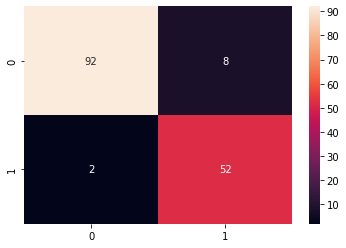

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])
Accuracy: 0.93
Precision: 0.86
Recall: 0.94
FPR: 0.06
FNR: 0.08


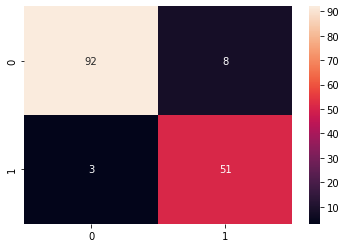

GaussianNB()
Accuracy: 0.91
Precision: 0.84
Recall: 0.91
FPR: 0.09
FNR: 0.09


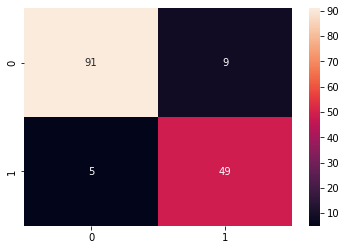

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])
Accuracy: 0.91
Precision: 0.83
Recall: 0.93
FPR: 0.07
FNR: 0.1


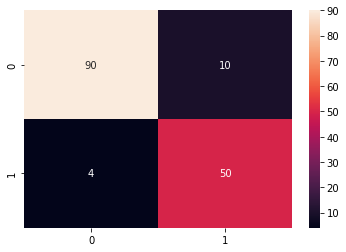

RandomForestClassifier(max_depth=3, random_state=0)
Accuracy: 0.95
Precision: 0.9
Recall: 0.96
FPR: 0.04
FNR: 0.06


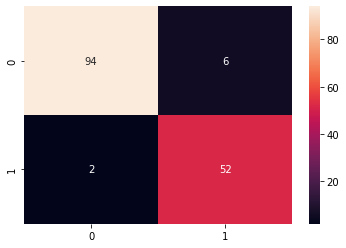

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Accuracy: 0.91
Precision: 0.88
Recall: 0.85
FPR: 0.15
FNR: 0.06


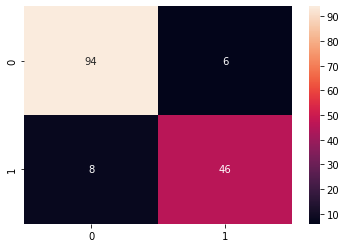

LGBMClassifier()
Accuracy: 0.9
Precision: 0.87
Recall: 0.85
FPR: 0.15
FNR: 0.07


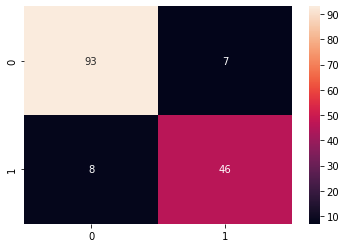

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=0)


/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.92
Precision: 0.87
Recall: 0.89
FPR: 0.11
FNR: 0.07


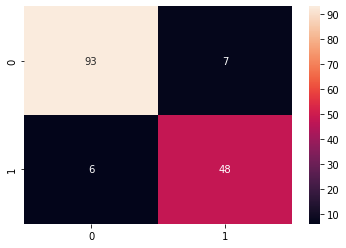

In [13]:
clfs = [DecisionTreeClassifier(random_state=0, max_depth=3),
        make_pipeline(StandardScaler(), SVC(gamma='auto')),
        GaussianNB(),
        make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3)),
        RandomForestClassifier(max_depth=3, random_state=0),
        GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
        LGBMClassifier(),
        XGBClassifier(verbosity=0)]
        
cv = LeaveOneOut()
for clf in clfs:
    print(clf)
    y_test_all = []
    y_pred_all = []
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        y_test_all.append(y_test[0])
        y_pred_all.append(y_pred[0])

    m = metrics(y_test_all, y_pred_all)
    print("Accuracy:", m["accuracy"])
    print("Precision:", m["precision"])
    print("Recall:", m["recall"])
    print("FPR:", m["false positive rate"])
    print("FNR:", m["false negative rate"])
    sns.heatmap(m["confusion matrix"], annot=True)
    plt.show()

[Text(186.0, 475.65000000000003, 'SIPF <= 0.0\ngini = 0.455\nsamples = 154\nvalue = [54, 100]\nclass = Bloom'),
 Text(93.0, 339.75, 'gini = 0.0\nsamples = 92\nvalue = [0, 92]\nclass = Bloom'),
 Text(279.0, 339.75, 'MPH0 <= 0.005\ngini = 0.225\nsamples = 62\nvalue = [54, 8]\nclass = No Bloom'),
 Text(186.0, 203.85000000000002, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = Bloom'),
 Text(372.0, 203.85000000000002, 'SICF <= -0.007\ngini = 0.18\nsamples = 60\nvalue = [54, 6]\nclass = No Bloom'),
 Text(279.0, 67.94999999999999, 'gini = 0.0\nsamples = 34\nvalue = [34, 0]\nclass = No Bloom'),
 Text(465.0, 67.94999999999999, 'gini = 0.355\nsamples = 26\nvalue = [20, 6]\nclass = No Bloom')]

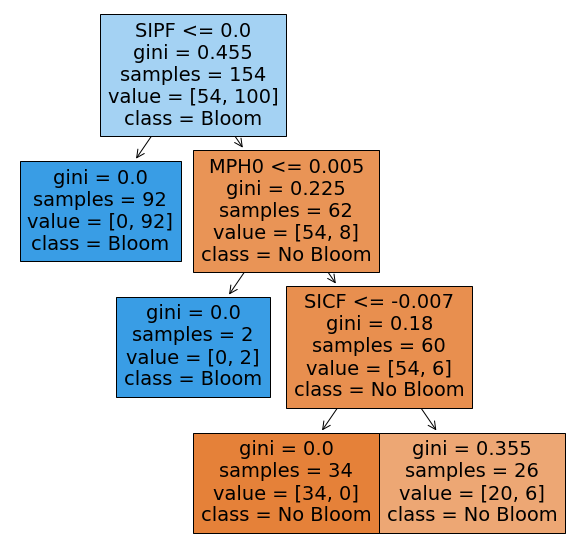

In [14]:
plt.figure(figsize=(10,10))
clf = DecisionTreeClassifier(random_state=0, max_depth=3)
clf.fit(X, y)
tree.plot_tree(clf, 
               feature_names=["NDVI", "BAIR", "SICF", "SIPF", "MPH0", "MPH1", "lambda_max1"],  
               class_names=["No Bloom", "Bloom"],
               filled=True)

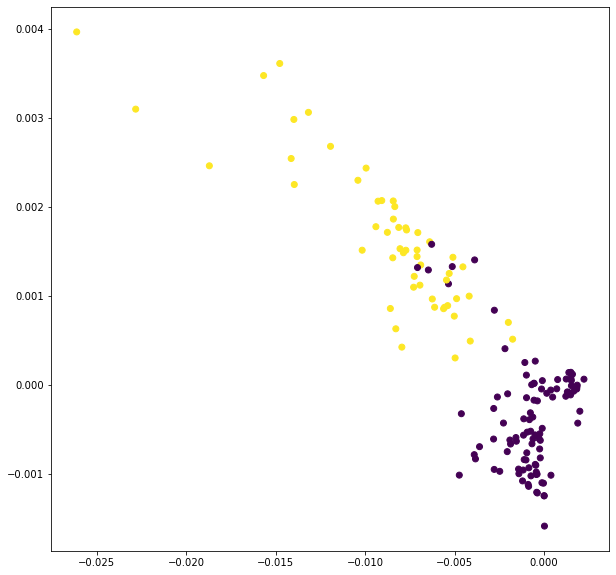

In [15]:
y_binary = np.zeros(y.shape)
for i in range(y_binary.shape[0]):
    if y[i] == "No Bloom":
        y_binary[i] = 0
    else:
        y_binary[i] = 1

plt.figure(figsize=(10,10))
plt.scatter(X[:, 2], X[:, 3], c=y_binary)
plt.show()

### Extend features using climate data

In [16]:
# climate_features_meta = {"precipitation": {"accumulation_days": 365, "accumulation_type": "sum"},
#                          "temperature": {"accumulation_days": 9, "accumulation_type": "max"},
#                          "wind": {"accumulation_days": 9, "accumulation_type": "max"}}
climate_features_meta = {"precipitation": {"accumulation_days": 200, "accumulation_type": "sum"}}
# climate_features_meta = {"precipitation": {"accumulation_days": 200, "accumulation_type": "sum"},
#                          "temperature": {"accumulation_days": 200, "accumulation_type": "mean"}
#                         }
climate_features = np.zeros((len(dates_list), len(climate_features_meta.keys())))
for idx, key_value in enumerate(climate_features_meta.items()):
    climate_feature_name = key_value[0]
    feature_metadata = key_value[1]
    feature_accumulated_data = []
    for date_idx, d in enumerate(dates_list):
        row_date = datetime(d.year, d.month, d.day, 0, 0, 0)
        historic_data = dataset.get_historic_data(row_date, feature_metadata["accumulation_days"])

        if len(historic_data) == 0:
            print(f"{d} has no historic data")
            continue

        climate_feature_value = getattr(historic_data[climate_feature_name], feature_metadata["accumulation_type"])()
        if isnan(climate_feature_value):
            print(historic_data[["date", climate_feature_name]])
            climate_feature_value = 0
        feature_accumulated_data.append(climate_feature_value)

    climate_features[:, idx] = np.array(feature_accumulated_data)
    
X_extended = np.hstack((X,climate_features))

## Prediction with MPH indexes and climate data

DecisionTreeClassifier(max_depth=3, random_state=0)
Accuracy: 0.92
Precision: 0.86
Recall: 0.93
FPR: 0.07
FNR: 0.08


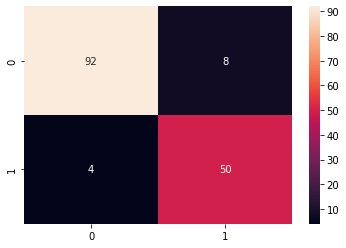

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])
Accuracy: 0.94
Precision: 0.89
Recall: 0.94
FPR: 0.06
FNR: 0.06


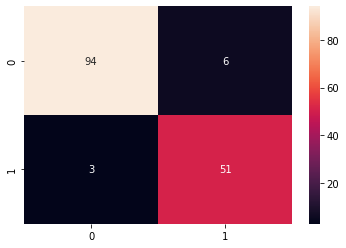

GaussianNB()
Accuracy: 0.92
Precision: 0.92
Recall: 0.83
FPR: 0.17
FNR: 0.04


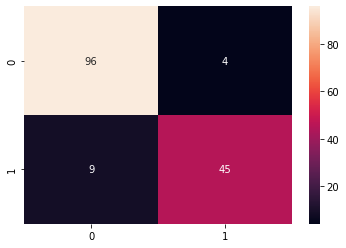

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])
Accuracy: 0.92
Precision: 0.89
Recall: 0.89
FPR: 0.11
FNR: 0.06


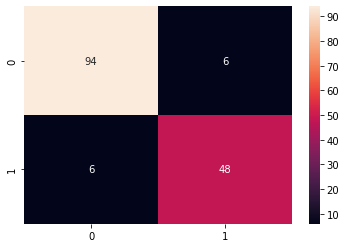

RandomForestClassifier(max_depth=3, random_state=0)
Accuracy: 0.94
Precision: 0.89
Recall: 0.93
FPR: 0.07
FNR: 0.06


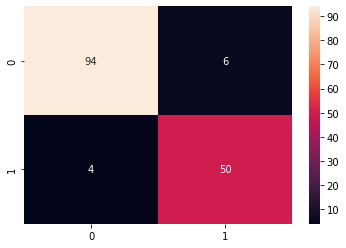

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Accuracy: 0.9
Precision: 0.88
Recall: 0.83
FPR: 0.17
FNR: 0.06


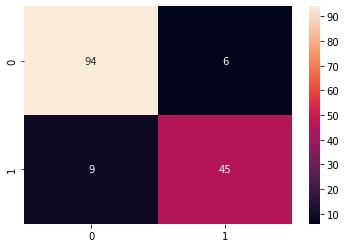

LGBMClassifier()
Accuracy: 0.9
Precision: 0.87
Recall: 0.85
FPR: 0.15
FNR: 0.07


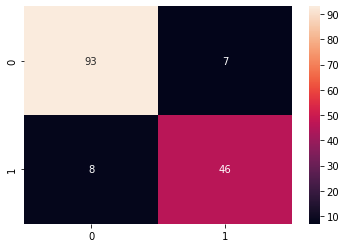

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=0)


/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.91
Precision: 0.88
Recall: 0.85
FPR: 0.15
FNR: 0.06


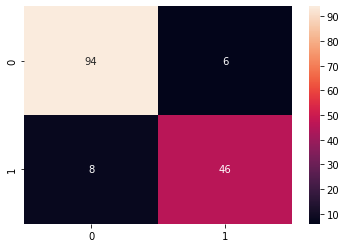

In [17]:
clfs = [DecisionTreeClassifier(random_state=0, max_depth=3),
        make_pipeline(StandardScaler(), SVC(gamma='auto')),
        GaussianNB(),
        make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3)),
        RandomForestClassifier(max_depth=3, random_state=0),
        GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
        LGBMClassifier(),
        XGBClassifier(verbosity=0)]
        

cv = LeaveOneOut()
for clf in clfs:
    print(clf)
    y_test_all = []
    y_pred_all = []
    for train_index, test_index in cv.split(X_extended, y):
        X_train, X_test = X_extended[train_index], X_extended[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        y_test_all.append(y_test[0])
        y_pred_all.append(y_pred[0])

    m = metrics(y_test_all, y_pred_all)
    print("Accuracy:", m["accuracy"])
    print("Precision:", m["precision"])
    print("Recall:", m["recall"])
    print("FPR:", m["false positive rate"])
    print("FNR:", m["false negative rate"])
    sns.heatmap(m["confusion matrix"], annot=True)
    plt.show()

## Train and save model

### Without climate data

In [18]:
# filename_no_climate = 'decision_tree_2023.sav'

# model = DecisionTreeClassifier(random_state=0, max_depth=3)

# model.fit(X, y)

# print(metrics(y, model.predict(X)))
# # save the model to disk
# pickle.dump(model, open(filename_no_climate, 'wb'))

### With climate data

In [19]:
# filename_with_climate = 'xgboost_precipitation_2023.sav'

# model = XGBClassifier(verbosity=0)

# model.fit(X_extended, y)

# print(metrics(y, model.predict(X_extended)))
# # save the model to disk
# pickle.dump(model, open(filename_with_climate, 'wb'))

## Load trained model from disk

In [20]:
# xgboost_model = pickle.load(open(filename_with_climate, 'rb'))
# decision_tree_model = pickle.load(open(filename_no_climate, 'rb'))

# xgboost_preds = xgboost_model.predict(X_extended)
# decision_tree_preds = decision_tree_model.predict(X)
# print(metrics(y, xgboost_preds))
# print(metrics(y, decision_tree_preds))

## Bloom forecast

0.3333333333333333
GaussianNB() 1 days pre bloom threshold


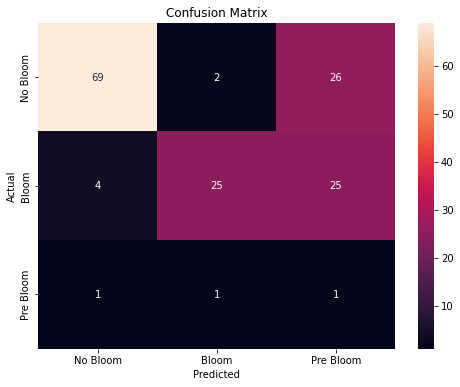

/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


1.0
GaussianNB() 2 days pre bloom threshold


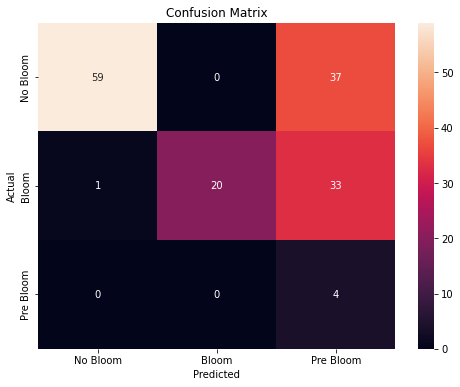

/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


1.0
GaussianNB() 3 days pre bloom threshold


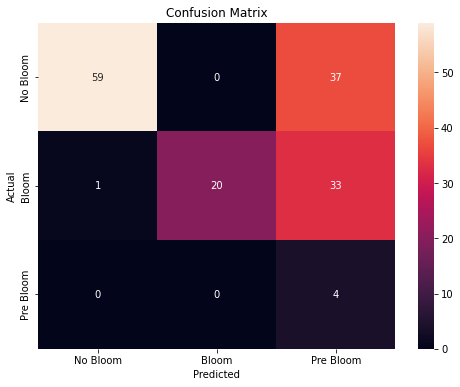

/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


1.0
GaussianNB() 4 days pre bloom threshold


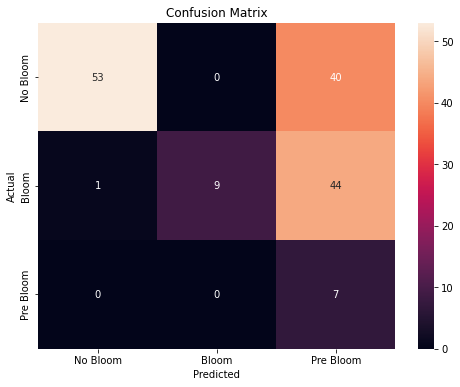

/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


1.0
GaussianNB() 5 days pre bloom threshold


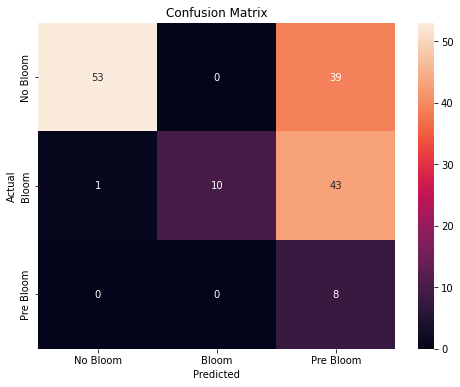

/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


1.0
GaussianNB() 6 days pre bloom threshold


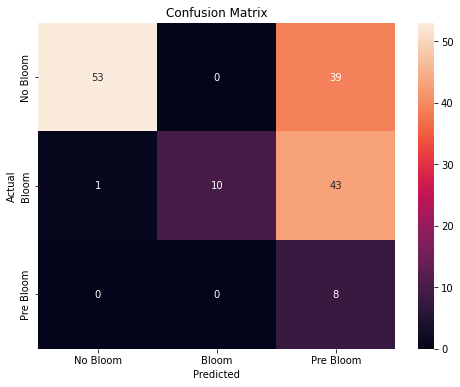

/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.3076923076923077
DecisionTreeClassifier(max_depth=3, random_state=0) 8 days pre bloom threshold


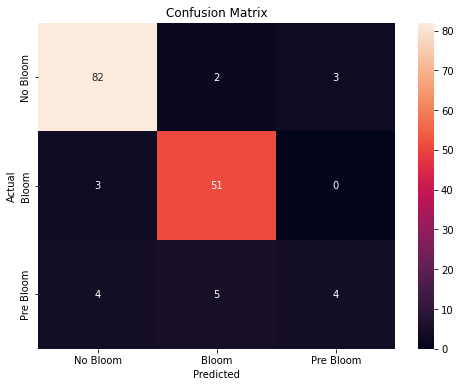

0.3076923076923077
GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0) 8 days pre bloom threshold


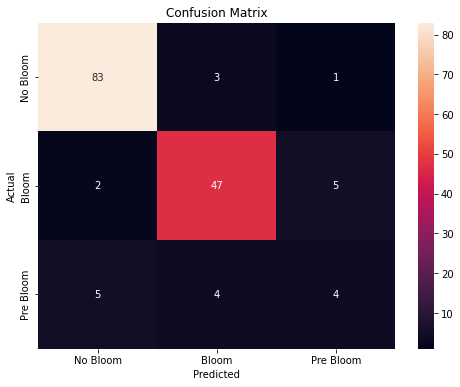

/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.3076923076923077
DecisionTreeClassifier(max_depth=3, random_state=0) 9 days pre bloom threshold


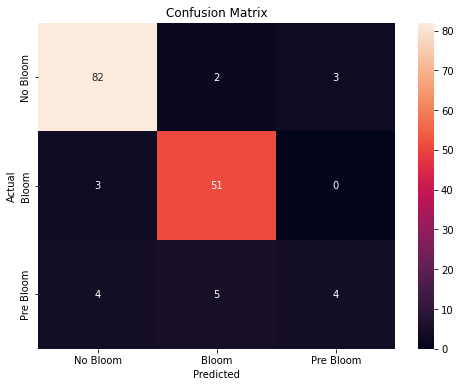

0.3076923076923077
GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0) 9 days pre bloom threshold


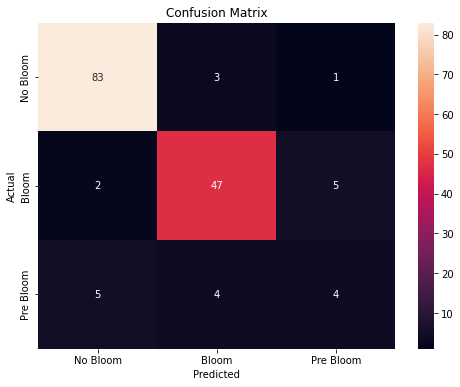

/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.3076923076923077
DecisionTreeClassifier(max_depth=3, random_state=0) 10 days pre bloom threshold


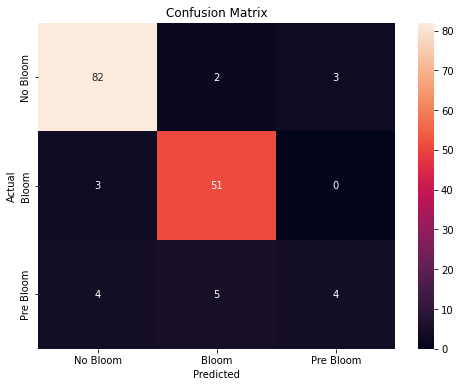

0.3076923076923077
GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0) 10 days pre bloom threshold


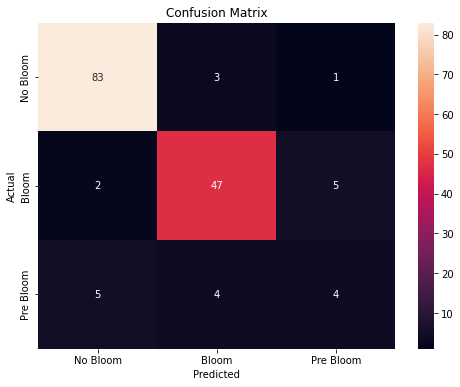

/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [21]:
forecast_metrics = []

for bloom_forecast_threshold in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    dataset.change_bloom_forecast_label(bloom_forecast_threshold)
    y_forecast = []
    for d, location in zip(dates_list, locations_list):
        location_condition = dataset.bloom_forecast_gt["location"] == location
        date_condition = dataset.bloom_forecast_gt["date"] == d

        forecast_label = dataset.bloom_forecast_gt[date_condition & location_condition]["forecast label"].to_list()
        if len(forecast_label) > 1: 
            print(f"{dataset.bloom_forecast_gt[date_condition & location_condition]}")
            break
        forecast_label = forecast_label[0]
        y_forecast.append(forecast_label)

    y_forecast = np.array(y_forecast)
    # Get unique classes and their counts
    unique_classes, class_counts = np.unique(y_forecast, return_counts=True)
    
    clfs = [DecisionTreeClassifier(random_state=0, max_depth=3),
        make_pipeline(StandardScaler(), SVC(gamma='auto')),
        GaussianNB(),
        make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3)),
        RandomForestClassifier(max_depth=3, random_state=0),
        GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
        LGBMClassifier(),
        XGBClassifier(verbosity=0)]
    
    cv = LeaveOneOut()
    for clf in clfs:
        y_test_all = []
        y_pred_all = []
        for train_index, test_index in cv.split(X_extended, y_forecast):
            X_train, X_test = X_extended[train_index], X_extended[test_index]
            y_train, y_test = y_forecast[train_index], y_forecast[test_index]

            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)

            y_test_all.append(y_test[0])
            y_pred_all.append(y_pred[0])

        m = metrics_multiclass(y_test_all, y_pred_all)
        cm = m["confusion matrix"]
        
        relevant_metrics = {"bloom threshold [days]": bloom_forecast_threshold}
        relevant_metrics["Pre Bloom instances on dataset"] = class_counts[2]
        relevant_metrics["Bloom accuracy"] = m["Accuracy"]["Bloom"]
        relevant_metrics["Pre Bloom accuracy"] = m["Accuracy"]["Pre Bloom"]
        relevant_metrics["No Bloom accuracy"] = m["Accuracy"]["No Bloom"]
        relevant_metrics["Pre Bloom + Bloom accuracy"] = cm[1:, 1:].sum()/cm[1:, 0:].sum()
        relevant_metrics["Model"] = str(clf)
        forecast_metrics.append(relevant_metrics)
        if m["Accuracy"]["Pre Bloom"] >= 0.25:
            print(m["Accuracy"]["Pre Bloom"])
            print(f"{clf} {bloom_forecast_threshold} days pre bloom threshold")
            # Create a heatmap of the confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(m["confusion matrix"], annot=True, fmt="d", xticklabels=["No Bloom", "Bloom", "Pre Bloom"], 
                                                        yticklabels=["No Bloom", "Bloom", "Pre Bloom"])
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix")
            plt.show()
forecast_metrics = pd.DataFrame(forecast_metrics)

In [22]:
forecast_metrics.sort_values(by=['Pre Bloom accuracy', 'Pre Bloom + Bloom accuracy'], ascending=False)

,bloom threshold [days],Pre Bloom instances on dataset,Bloom accuracy,Pre Bloom accuracy,No Bloom accuracy,Pre Bloom + Bloom accuracy,Model
34,5,8,0.185185,1.0,0.576087,0.983871,GaussianNB()
42,6,8,0.185185,1.0,0.576087,0.983871,GaussianNB()
26,4,7,0.166667,1.0,0.569892,0.983607,GaussianNB()
10,2,4,0.370370,1.0,0.614583,0.982759,GaussianNB()
18,3,4,0.370370,1.0,0.614583,0.982759,GaussianNB()
...,...,...,...,...,...,...,...
60,8,13,0.962963,0.0,0.965517,0.850746,"RandomForestClassifier(max_depth=3, random_sta..."
65,9,13,0.962963,0.0,0.988506,0.850746,"Pipeline(steps=[('standardscaler', StandardSca..."
68,9,13,0.962963,0.0,0.965517,0.850746,"RandomForestClassifier(max_depth=3, random_sta..."
73,10,13,0.962963,0.0,0.988506,0.850746,"Pipeline(steps=[('standardscaler', StandardSca..."


In [23]:
forecast_metrics.sort_values(by=['bloom threshold [days]'], ascending=True)

,bloom threshold [days],Pre Bloom instances on dataset,Bloom accuracy,Pre Bloom accuracy,No Bloom accuracy,Pre Bloom + Bloom accuracy,Model
0,1,3,0.925926,0.000000,0.907216,0.929825,"DecisionTreeClassifier(max_depth=3, random_sta..."
1,1,3,0.944444,0.000000,0.958763,0.929825,"Pipeline(steps=[('standardscaler', StandardSca..."
2,1,3,0.462963,0.333333,0.711340,0.912281,GaussianNB()
3,1,3,0.925926,0.000000,0.958763,0.912281,"Pipeline(steps=[('standardscaler', StandardSca..."
4,1,3,0.962963,0.000000,0.958763,0.947368,"RandomForestClassifier(max_depth=3, random_sta..."
...,...,...,...,...,...,...,...
74,10,13,0.833333,0.153846,0.965517,0.835821,GaussianNB()
75,10,13,0.962963,0.000000,0.931034,0.880597,"Pipeline(steps=[('standardscaler', StandardSca..."
76,10,13,0.962963,0.000000,0.965517,0.850746,"RandomForestClassifier(max_depth=3, random_sta..."
77,10,13,0.870370,0.307692,0.954023,0.895522,"GradientBoostingClassifier(learning_rate=1.0, ..."
